In [100]:
import pandas as pd
import eurostat

In [101]:
df = eurostat.get_data_df(code="HBS_STR_T223")
df = df.rename(columns={'geo\TIME_PERIOD': 'geo', '2015':'OBS_VALUE'})


In [102]:
# Keep only the rows where TIME_PERIOD is equal to 2015
df = df.loc[:, ['quantile','coicop','geo','OBS_VALUE']]


In [103]:
df_inflation = eurostat.get_data_df(code="PRC_HICP_MANR",filter_pars={'startPeriod':"2021-01"})
df_inflation = df_inflation.rename(columns={'geo\TIME_PERIOD': 'geo'})


In [104]:
merged_df = df.merge(df_inflation, on=["coicop", "geo"])


In [105]:
cols_to_multiply = [col for col in merged_df.columns if col.startswith('202')]
merged_df[['w' + col for col in cols_to_multiply]] = merged_df[cols_to_multiply].apply(lambda x: x * merged_df['OBS_VALUE']/1000)


In [106]:
merged_df_5_chars = merged_df[merged_df['coicop'].str.len() == 5]


In [107]:
columns_to_sum = [col for col in merged_df_5_chars.columns if col.startswith('w')]
                  
summed_columns = []
for col in columns_to_sum:
    new_col_name = col[1:]
    summed_columns.append(new_col_name)
    merged_df_5_chars[new_col_name] = merged_df_5_chars.groupby(['geo', 'quantile'])[col].transform('sum')

df_inflation_by_quintile = merged_df_5_chars[['geo', 'quantile'] + summed_columns].drop_duplicates()

C:\Users\mdaversa\AppData\Local\Temp\ipykernel_29020\899747291.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_5_chars[new_col_name] = merged_df_5_chars.groupby(['geo', 'quantile'])[col].transform('sum')
C:\Users\mdaversa\AppData\Local\Temp\ipykernel_29020\899747291.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_5_chars[new_col_name] = merged_df_5_chars.groupby(['geo', 'quantile'])[col].transform('sum')
C:\Users\mdaversa\AppData\Local\Temp\ipykernel_29020\899747291.py:7: Setting

In [108]:
# For EU27_2020, only the groups of coicop with 4 characters have value

merged_df_4_chars = merged_df[merged_df['coicop'].str.len() == 4]
merged_df_4_chars = merged_df_4_chars.loc[(merged_df_4_chars['geo'] == 'EU27_2020')]
summed_columns = []
for col in columns_to_sum:
    new_col_name = col[1:]
    summed_columns.append(new_col_name)
    merged_df_4_chars[new_col_name] = merged_df_4_chars.groupby(['geo', 'quantile'])[col].transform('sum')

df_inflation_by_quintile_eu27 = merged_df_4_chars[['geo', 'quantile'] + summed_columns].drop_duplicates()


In [109]:
df_inflation_by_quintile = pd.concat([df_inflation_by_quintile, df_inflation_by_quintile_eu27])

In [110]:
# we drop Italy and EA because they don't have the values, and TR because they have a crazy high inflation
df_inflation_by_quintile = df_inflation_by_quintile.loc[~df_inflation_by_quintile['geo'].isin(['IT', 'EA', 'TR'])]

In [111]:
value_vars = df_inflation_by_quintile.filter(regex='^202').columns


In [112]:
df_inflation_by_quintile_melt = df_inflation_by_quintile.melt(id_vars=["geo", "quantile"], value_vars=value_vars, var_name="month", value_name="inflation")

In [113]:
df_pivot = df_inflation_by_quintile_melt.pivot_table(index=['geo', 'month'], columns='quantile', values='inflation').reset_index()

df_pivot['Q1/Q5'] = df_pivot['QUINTILE1'] / df_pivot['QUINTILE5']

quintile_columns = ['QUINTILE1', 'QUINTILE2', 'QUINTILE3', 'QUINTILE4', 'QUINTILE5']
quintiles_df = df_pivot[quintile_columns]

df_pivot['normalized_std'] = quintiles_df.std(axis=1) / quintiles_df.mean(axis=1)

df_pivot['Q1-Q5'] = df_pivot['QUINTILE1'] - df_pivot['QUINTILE5']
df_pivot['(Q1-Q5)/Q1'] = (df_pivot['QUINTILE1'] - df_pivot['QUINTILE5'])/df_pivot['QUINTILE1']

df_inflation_by_quintile = df_pivot.reset_index(drop=True)
df_inflation_by_quintile = df_inflation_by_quintile.drop(["UNK"], axis=1)

# Energy inflation

In [114]:
df_inflation_NRG = df_inflation[df_inflation["coicop"] == "NRG"]

In [115]:
df_inflation_NRG = df_inflation_NRG.melt(id_vars=["geo"], value_vars=value_vars, var_name="month", value_name="inflationNRG")

In [116]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(df_inflation_NRG, on=["geo", "month"])

# Food inflation

In [117]:
df_inflation_FOOD = df_inflation[df_inflation["coicop"] == "FOOD"]

In [118]:
df_inflation_FOOD = df_inflation_FOOD.melt(id_vars=["geo"], value_vars=value_vars, var_name="month", value_name="inflationFOOD")

In [119]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(df_inflation_FOOD, on=["geo", "month"])

# Services inflation

In [120]:
df_inflation_SERV = df_inflation[df_inflation["coicop"] == "SERV"]

In [121]:
df_inflation_SERV = df_inflation_SERV.melt(id_vars=["geo"], value_vars=value_vars, var_name="month", value_name="inflationSERV")

In [122]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(df_inflation_SERV, on=["geo", "month"])

In [123]:
df_inflation_by_quintile['inflationNRG/SERV'] = df_inflation_by_quintile['inflationNRG'] / df_inflation_by_quintile['inflationSERV']

# Gini

In [124]:
gini = eurostat.get_data_df(code="TESSI190")

In [125]:
import numpy as np

def get_most_recent(row):
    for year in range(2022, 2010, -1):
        if not pd.isnull(row[str(year)]):
            return row[str(year)]
    return np.nan

gini["most_recent"] = gini.apply(get_most_recent, axis=1)
gini = gini.rename(columns={"geo\TIME_PERIOD": "geo"})
gini = gini.loc[:, ["geo", "most_recent"]]
gini = gini.rename(columns={"most_recent": "gini"})


In [126]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(gini, on="geo")

# Price levels

In [127]:
price_levels_energy = eurostat.get_data_df(code="prc_ppp_ind", filter_pars={'startPeriod':"2021", "endPeriod":"2021", "ppp_cat":["A010405"], "na_item":"PLI_EU27_2020"})
price_levels_energy = price_levels_energy.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "energy_price_level"})
price_levels_energy = price_levels_energy.loc[:, ["geo", "energy_price_level"]]



In [128]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(right=price_levels_energy, on="geo")

In [129]:
price_levels_transport = eurostat.get_data_df(code="prc_ppp_ind", filter_pars={'startPeriod':"2021", "endPeriod":"2021", "ppp_cat":["A0107"], "na_item":"PLI_EU27_2020"})
price_levels_transport = price_levels_transport.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "transport_price_level"})
price_levels_transport = price_levels_transport.loc[:, ["geo", "transport_price_level"]]

In [130]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(right=price_levels_transport, on="geo")

# GDP per capita

In [131]:
code = "NAMA_10_PC"
gdp = eurostat.get_data_df(code=code, filter_pars={'startPeriod':"2021", "endPeriod":"2021", "unit": "CP_EUR_HAB", "na_item":"B1GQ"})
gdp = gdp.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "gdp"})
gdp = gdp.loc[:, ["geo", "gdp"]]

In [132]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(right=gdp, on="geo")

# Government expenditure

In [133]:
code = "GOV_10A_EXP"
gov_exp = eurostat.get_data_df(code=code, filter_pars={'startPeriod':"2021", "endPeriod":"2021", "na_item":"TE", "sector":"S13", "unit":"PC_GDP", "cofog99": "TOTAL"})
gov_exp = gov_exp.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "gov_exp"})
gov_exp = gov_exp.loc[:, ["geo", "gov_exp"]]

In [134]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(right=gov_exp, on="geo")

In [135]:
code = "GOV_10A_EXP"
gov_exp_social = eurostat.get_data_df(code=code, filter_pars={'startPeriod':"2021", "endPeriod":"2021", "na_item":"TE", "sector":"S13", "unit":"PC_GDP", "cofog99": "GF10"})
gov_exp_social = gov_exp_social.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "gov_exp_social"})
gov_exp_social = gov_exp_social.loc[:, ["geo", "gov_exp_social"]]

In [136]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(right=gov_exp_social, on="geo")

# Urbanisation

In [137]:
code = "ILC_LVHO01"
urbanisation = eurostat.get_data_df(code=code, filter_pars={"endPeriod":"2022", "incgrp":"TOTAL", "building": "TOTAL", "deg_urb": "DEG1"})

urbanisation["most_recent"] = urbanisation.apply(get_most_recent, axis=1)


urbanisation = urbanisation.rename(columns={"geo\TIME_PERIOD":"geo", "most_recent": "urbanisation"})
urbanisation = urbanisation.loc[:, ["geo", "urbanisation"]]

In [138]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(urbanisation, on="geo")

# Share of electric consumption in final energy consumption

In [139]:
code = "NRG_IND_FECF"
electric_share = eurostat.get_data_df(code=code, filter_pars={"startPeriod":"2021", "endPeriod":"2021", "nrg_bal":"FC_E","siec":"E7000"})



electric_share = electric_share.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "electric_share"})
electric_share = electric_share.loc[:, ["geo", "electric_share"]]

In [140]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(electric_share, on="geo")

# At-risk-of-poverty rate before social transfers

In [141]:
code = "ILC_LI10"
poverty = eurostat.get_data_df(code=code, filter_pars={"startPeriod":"2011", "endPeriod":"2022", "age": "total", "indic_il":"LI_R_MD60BT", "sex":"T"})

poverty["most_recent"] = poverty.apply(get_most_recent, axis=1)


poverty = poverty.rename(columns={"geo\TIME_PERIOD":"geo", "most_recent": "poverty"})
poverty = poverty.loc[:, ["geo", "poverty"]]

In [142]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(poverty, on="geo")

# Import

In [143]:
code = "TET00004"
importation = eurostat.get_data_df(code=code, filter_pars={"startPeriod":"2011", "endPeriod":"2021"})


importation = importation.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "importation"})
importation = importation.loc[:, ["geo", "importation"]]

In [144]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(importation, on="geo")

# Analysis

# PCA

c:\Users\mdaversa\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\mdaversa\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


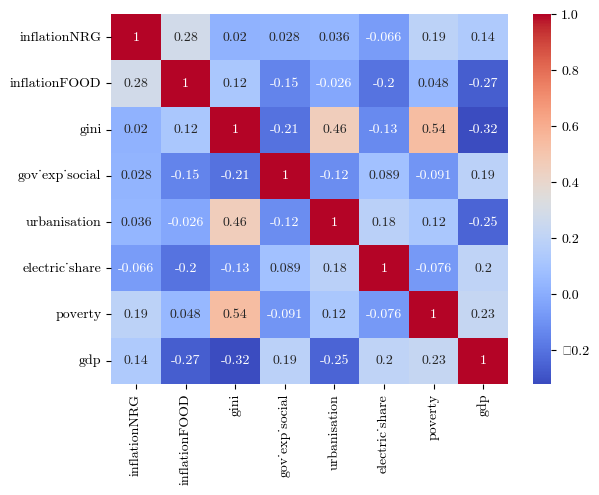

In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Définir les variables d'entrée (X)
X = df_inflation_by_quintile[['inflationNRG', 'inflationFOOD', 'gini', 'gov_exp_social', 'urbanisation', 'electric_share', 'poverty', 'gdp']]

# Calculer la matrice de corrélation
corr_matrix = X.corr()

# Afficher la matrice de corrélation sous forme de heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()



# Auto regressive

In [147]:
import statsmodels.api as sm

X = df_inflation_by_quintile[['inflationNRG', 'inflationFOOD', 'gini', 'gov_exp_social', 'urbanisation', 'electric_share', 'importation']]
Y = df_inflation_by_quintile['Q1-Q5']

X = sm.add_constant(X)

lags = 1

for i in range(1, lags+1):
    X['Q1-Q5_lag{}'.format(i)] = Y.shift(i)

X = X.dropna()
Y = Y[X.index]

model = sm.OLS(Y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Q1-Q5   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     604.9
Date:                Wed, 10 May 2023   Prob (F-statistic):          1.53e-322
Time:                        16:09:16   Log-Likelihood:                -609.45
No. Observations:                 765   AIC:                             1237.
Df Residuals:                     756   BIC:                             1279.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.4697      0.253     -1.

In [148]:
# Replace infinite values with NaN
df_inflation_by_quintile = df_inflation_by_quintile.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values and 0 values
df_inflation_by_quintile = df_inflation_by_quintile.dropna()
df_inflation_by_quintile = df_inflation_by_quintile[df_inflation_by_quintile != 0].dropna()

# Define the maximum number of lags
max_lag = 1

# Create an empty DataFrame to store the lagged values
df_lagged = pd.DataFrame()

# Loop through each region and add the lagged values to the DataFrame
for geo in df_inflation_by_quintile['geo'].unique():
    # Subset the data for the current region
    df_region = df_inflation_by_quintile[df_inflation_by_quintile['geo']==geo]
    # Add the lagged values to the DataFrame for the current region
    for i in range(1, max_lag+1):
        df_region['Q1-Q5_lag{}'.format(i)] = df_region['Q1-Q5'].shift(i)
    # Append the lagged values for the current region to the overall DataFrame
    df_lagged = pd.concat([df_lagged, df_region], ignore_index=True)

# Remove rows with missing values
df_lagged = df_lagged.dropna()

# Select target variable and explanatory variables, including the lagged values
X = df_lagged[['inflationNRG/SERV','gov_exp_social',  'gini', 'urbanisation', 'electric_share', 'Q1-Q5_lag1']]
Y = df_lagged['Q1-Q5']

# Add a constant to the explanatory variables
X = sm.add_constant(X)

# Fit the AR model
model = sm.OLS(Y, X).fit()

# Print the summary of results
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                  Q1-Q5   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     658.9
Date:                Wed, 10 May 2023   Prob (F-statistic):          1.96e-282
Time:                        16:09:19   Log-Likelihood:                -618.12
No. Observations:                 700   AIC:                             1250.
Df Residuals:                     693   BIC:                             1282.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2063      0.23

C:\Users\mdaversa\AppData\Local\Temp\ipykernel_29020\2522653222.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_region['Q1-Q5_lag{}'.format(i)] = df_region['Q1-Q5'].shift(i)
C:\Users\mdaversa\AppData\Local\Temp\ipykernel_29020\2522653222.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_region['Q1-Q5_lag{}'.format(i)] = df_region['Q1-Q5'].shift(i)
C:\Users\mdaversa\AppData\Local\Temp\ipykernel_29020\2522653222.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [152]:
# Replace infinite values with NaN
df_inflation_by_quintile = df_inflation_by_quintile.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values and 0 values
df_inflation_by_quintile = df_inflation_by_quintile.dropna()
df_inflation_by_quintile = df_inflation_by_quintile[df_inflation_by_quintile != 0].dropna()

# Define the maximum number of lags
max_lag = 4

# Create an empty DataFrame to store the lagged values
df_lagged = pd.DataFrame()

# Loop through each region and add the lagged values to the DataFrame
for geo in df_inflation_by_quintile['geo'].unique():
    # Subset the data for the current region
    df_region = df_inflation_by_quintile[df_inflation_by_quintile['geo']==geo]
    # Add the lagged values to the DataFrame for the current region
    for i in range(1, max_lag+1):
        df_region['Q1-Q5_lag{}'.format(i)] = df_region['Q1-Q5'].shift(i)
    # Append the lagged values for the current region to the overall DataFrame
    df_lagged = pd.concat([df_lagged, df_region], ignore_index=True)

# Remove rows with missing values
df_lagged = df_lagged.dropna()

# Select target variable and explanatory variables, including the lagged values
X = df_lagged[['inflationNRG/SERV','gov_exp_social',  'gini', 'urbanisation', 'electric_share', 'Q1-Q5_lag1','Q1-Q5_lag2', 'Q1-Q5_lag3', 'Q1-Q5_lag4']]
Y = df_lagged['Q1-Q5']

# Add a constant to the explanatory variables
X = sm.add_constant(X)

# Fit the AR model
model = sm.OLS(Y, X).fit()

summary = model.summary()
# Print the summary of results
print(summary)





                            OLS Regression Results                            
Dep. Variable:                  Q1-Q5   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     401.5
Date:                Wed, 10 May 2023   Prob (F-statistic):          1.10e-248
Time:                        16:14:38   Log-Likelihood:                -559.77
No. Observations:                 616   AIC:                             1140.
Df Residuals:                     606   BIC:                             1184.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2465      0.25

C:\Users\mdaversa\AppData\Local\Temp\ipykernel_29020\3497544665.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_region['Q1-Q5_lag{}'.format(i)] = df_region['Q1-Q5'].shift(i)
C:\Users\mdaversa\AppData\Local\Temp\ipykernel_29020\3497544665.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_region['Q1-Q5_lag{}'.format(i)] = df_region['Q1-Q5'].shift(i)
C:\Users\mdaversa\AppData\Local\Temp\ipykernel_29020\3497544665.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

# AutoReg

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np

df = df_inflation_by_quintile
fig, ax = plt.subplots(figsize=(16,8))
plot_acf(df['Q1-Q5'], lags=50, ax=ax)
plt.ylim([0,1])
plt.yticks(np.arange(0.1, 1.1, 0.1))
plt.xticks(np.arange(1, 51, 1))
plt.axhline(y=0.5, color="green")

ax.set_title('Autocorrelation plot for difference in inflation rates by quintile')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')

plt.rcParams['font.family'] = 'cmr10'


In [ ]:
import pandas as pd
from statsmodels.tsa.api import AutoReg

# Charger les données
df = df_inflation_by_quintile

# Formater les données pour être utilisées dans AutoReg
df = df.set_index(['month', 'geo'])
Y = df['Q1-Q5']
X = df[["inflationNRG/SERV", "gov_exp_social"]]

# Définir les paramètres du modèle
lags = 4  # nombre de lags
trend = 'c'  # tendance ('c' constante, 't' linéaire, None aucune)

# Créer le modèle AutoReg et l'ajuster aux données
model = AutoReg(Y, lags=lags, trend=trend, exog=X)
results = model.fit()

# Vérifier les résultats
print(results.summary())
